### Imports

In [1]:
import cv2
import time

import requests
import numpy as np
import matplotlib.pyplot as plt

from PIL import ImageFont, ImageDraw, Image

from helpers.limbus_detection import detect_circle
from helpers.bioniko_detection import detect_bioniko
from helpers.orientation_detection import detect_markers_entropy, detect_markers_hu_moments
from helpers.keypoint_based_tracking import estimate_transform, get_transform_info
from helpers.misc import get_avg_laplacian, get_in_out_intensity_diff, get_mean_intensity, \
    jiggle_circle, tighten_circle
from helpers.view_detection import get_view_mask


%load_ext autoreload
%autoreload 2

### 1. video demo playback

In [2]:
#
cap = cv2.VideoCapture('data/artificial/procedure4_lofi.mkv')

while cap.isOpened():
    ret, frame = cap.read() 
  
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
  
    circles = cv2.HoughCircles(
        cv2.GaussianBlur(255 - gray, ksize=(0,0), sigmaX=2),
        cv2.HOUGH_GRADIENT, dp=1, minDist=1,
        param1=120, param2=40,
        minRadius=gray.shape[0]//10, maxRadius=round(gray.shape[0]/1.2)
    )
    
    if circles is not None:
        circles_filtered = np.uint16(np.around(circles[0,:1,:]))
        for i, circle in enumerate(circles_filtered):
            cv2.circle(frame, (circle[0], circle[1]), circle[2], (0, 255, 0), 1)
            cv2.putText(frame, str(i + 1), (circle[0], circle[1]), cv2.FONT_HERSHEY_PLAIN, 1, (0, 255, 0), 1)
  
    cv2.imshow('original', frame)

    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

### 2. video demo capture

In [36]:
#
cap = cv2.VideoCapture('data/artificial/procedure3_lofi.mkv')
out = cv2.VideoWriter('test.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30,
    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

while cap.isOpened():
    ret, frame = cap.read() 
    if ret == False:
        break
  
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
  
    circles = cv2.HoughCircles(
        cv2.GaussianBlur(255 - gray, ksize=(0,0), sigmaX=2),
        cv2.HOUGH_GRADIENT, dp=1, minDist=10,
        param1=120, param2=40,
        minRadius=gray.shape[0]//10, maxRadius=int(gray.shape[0]/1.5)
    )
    
    if circles is not None:
        circles_filtered = np.uint16(np.around(circles[0,:1,:]))
        for i, circle in enumerate(circles_filtered):
            cv2.circle(frame, (circle[0], circle[1]), circle[2], (0, 255, 0), 1)
            cv2.drawMarker(frame, (circle[0], circle[1]), (0, 255, 0))
  
    out.write(frame)

    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break

cap.release()
out.release()                      
cv2.destroyAllWindows() 

### 3. realtime demo

In [ ]:
#
url = 'http://192.168.0.207:8080/shot.jpg'

while True:
    response = requests.get(url)
    img_arr = np.array(bytearray(response.content), dtype=np.uint8)
    img = cv2.imdecode(img_arr, -1)
    
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  
    circles = cv2.HoughCircles(
        cv2.GaussianBlur(255 - img_gray, ksize=(0,0), sigmaX=2),
        cv2.HOUGH_GRADIENT, dp=1, minDist=10,
        param1=120, param2=40,
        minRadius=img_gray.shape[0]//10, maxRadius=img_gray.shape[0]//2
    )
    
    if circles is not None:
        circles_filtered = np.uint16(np.around(circles[0,:1,:]))
        for i, circle in enumerate(circles_filtered):
            cv2.circle(img, (circle[0], circle[1]), circle[2], (0, 255, 0), 1)
            cv2.drawMarker(img, (circle[0], circle[1]), (0, 255, 0))
    
    cv2.imshow('android', img)

    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cv2.destroyAllWindows() 

### 4. video demo with smoothing

In [3]:
#
window_size = 30
scale = 0.25

cap = cv2.VideoCapture('data/artificial/procedure1.mp4')

frame_num = 0
window_circles = np.zeros((window_size,3))
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
  
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, None, fx=scale, fy=scale)
  
    circles = cv2.HoughCircles(
        cv2.GaussianBlur(255 - gray, ksize=(0,0), sigmaX=2),
        cv2.HOUGH_GRADIENT, dp=1, minDist=10,
        param1=120, param2=40,
        minRadius=gray.shape[0]//10, maxRadius=gray.shape[0]
    )
    
    if circles is not None:
        circles *= (1/scale)
        if frame_num == 0:
            window_circles[:,:] = circles[0,0,:]
        else:
            window_circles[frame_num % window_size,:] = circles[0,0,:]
        frame_num += 1
        
    smoothed_circle = np.mean(window_circles, axis=0)
    smoothed_circle = np.uint16(np.around(smoothed_circle))

    cv2.circle(frame, (smoothed_circle[0], smoothed_circle[1]),
        smoothed_circle[2], (0, 255, 0), 1)
    cv2.drawMarker(frame, (smoothed_circle[0], smoothed_circle[1]),
        (0, 255, 0))

    cv2.imshow('original', frame)

    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

### 5. video demo with pupil and orientation

In [8]:
#
cap = cv2.VideoCapture('data/artificial/procedure3_lofi.mkv')

while cap.isOpened():
    ret, base = cap.read()
    base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY) 
  
    iris_circles = cv2.HoughCircles(
        cv2.GaussianBlur(255 - base_gray, ksize=(0,0), sigmaX=2),
        cv2.HOUGH_GRADIENT, dp=1, minDist=10,
        param1=120, param2=40,
        minRadius=base_gray.shape[0]//10, maxRadius=base_gray.shape[0]//2
    )
    
    if iris_circles is not None:
        # limbus
        iris_circle = np.uint16(np.around(iris_circles[0,0,:]))
        cv2.circle(base, (iris_circle[0], iris_circle[1]), iris_circle[2], (0, 255, 0), 1)
        cv2.drawMarker(base, (iris_circle[0], iris_circle[1]), (0, 255, 0))
        
        # pupil
        iris_pupil_mask = np.zeros(base.shape[:2], dtype=np.uint8)
        cv2.circle(iris_pupil_mask, (iris_circle[0], iris_circle[1]), iris_circle[2] - 20, 255, cv2.FILLED)

        base_gray_blur = cv2.GaussianBlur(base_gray, ksize=(0,0), sigmaX=2)
        base_roi_values = base_gray_blur[np.where(iris_pupil_mask == 255)]
        thres_otsu, _ = cv2.threshold(
            src=base_roi_values,
            thresh=0,
            maxval=255,
            type=cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU
        )

        base_gray_roi_thres = base_gray_blur.copy()
        base_gray_roi_thres[np.where(base_gray_roi_thres > thres_otsu)] = 255
        base_gray_roi_thres[np.where(base_gray_roi_thres <= thres_otsu)] = 0
        base_gray_roi_thres[np.where(iris_pupil_mask == 0)[0],np.where(iris_pupil_mask == 0)[1]] = 255//2

        base_pupil_gray = base_gray_blur.copy()
        base_pupil_gray[np.where(base_gray_roi_thres > thres_otsu)] = 255
        base_pupil_gray[np.where(base_gray_roi_thres <= thres_otsu)] = 0
        base_pupil_gray[np.where(iris_pupil_mask == 0)[0],np.where(iris_pupil_mask == 0)[1]] = 0
        pupil_circles = cv2.HoughCircles(
            cv2.GaussianBlur(base_pupil_gray, ksize=(0,0), sigmaX=2),
            cv2.HOUGH_GRADIENT, dp=1, minDist=10,
            param1=150, param2=1,
            minRadius=base_pupil_gray.shape[0]//10, maxRadius=int((7/10)*iris_circle[2])
        )
        
        if pupil_circles is not None:
            pupil_circle = np.uint16(np.around(pupil_circles[0,0,:]))

            cv2.circle(base, (pupil_circle[0], pupil_circle[1]), pupil_circle[2], (0, 255, 0), 1)

            # orientation
            thresh_percentage = 0.01
            
            iris_mask = iris_pupil_mask.copy()
            cv2.circle(iris_mask, (pupil_circle[0], pupil_circle[1]), pupil_circle[2], 0, cv2.FILLED)
            iris_values = base_gray[np.where(iris_mask == 255)[0],np.where(iris_mask == 255)[1]]
            
            low_thres = np.sort(iris_values)[int(thresh_percentage * iris_values.size)]
            iris_low = base_gray.copy()
            _, iris_low = cv2.threshold(iris_low, thresh=low_thres, maxval=255, type=cv2.THRESH_BINARY_INV)
            iris_low = cv2.bitwise_and(iris_low, iris_mask)
            
            kernel = np.ones((2,2), dtype=np.uint8)

            morphed = iris_low.copy()
            morphed = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, kernel, iterations=1)
            morphed = cv2.dilate(morphed, kernel, iterations=10)

            iris_center = np.array((iris_circle[0], iris_circle[1]))

            bioniko_center = np.mean(np.array(np.where(morphed == 255)), axis=1)
            bioniko_center = np.uint16(np.flip(bioniko_center))

            orientation = bioniko_center - iris_center
            start_point = iris_center + orientation
            end_point = iris_center - orientation

            cv2.drawMarker(base, tuple(bioniko_center), (0, 255, 0))
            cv2.line(
                base,
                tuple(start_point),
                tuple(end_point),
                [0, 255, 0], thickness=2
            )
        

    cv2.imshow('result', base)
    cv2.imshow('pupil', base_pupil_gray)
    cv2.imshow('bioniko marker thresholded', iris_low)
    cv2.imshow('bioniko marker morphed', morphed)

    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

### 6. video demo with cross-correlation based orientation detection

In [9]:
#
cap = cv2.VideoCapture('data/artificial/procedure4_lofi.mkv')

base_polar = None
base_ccoef = None
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:,:,2]
    
    ret = detect_circle(base_value)
    if ret is not None:
        limbus_center, limbus_radius = ret[:2], ret[2]
        bioniko_loc, base_polar, base_ccoef = detect_bioniko(
            base_value, limbus_center, limbus_radius, return_verbose=True)
        
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        bioniko_loc_t = tuple(np.around(bioniko_loc).astype('int'))
        
        # overlay
        cv2.drawMarker(base, limbus_center_t, (0,255,0))
        cv2.circle(base, limbus_center_t, round(limbus_radius), (0,255,0))
        cv2.line(base, limbus_center_t, bioniko_loc_t, (0,255,0))

    cv2.imshow('result', base)
    cv2.imshow('base polar', base_polar)
    cv2.imshow('base sqdiff', base_ccoef)

    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

### 7. limbus validation using laplacian image

In [12]:
#
cap = cv2.VideoCapture('data/artificial/procedure1.mp4')

base_polar = None
base_sqdiff = None
arg_maxima = []
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:,:,2]
    base_laplacian = cv2.Laplacian(base_value, cv2.CV_16S)
    
    circles = detect_circle(base_value, return_all=True)
    
    if circles is not None:
        avg_laplacians = np.zeros(circles.shape[0])
        for index, circle in enumerate(circles):
            limbus_center = tuple(np.round(circle[:2]).astype('int'))
            limbus_radius = round(circle[2])
            avg_laplacians[index] = get_avg_laplacian(base_laplacian, limbus_center, limbus_radius)
        best_circle = circles[np.argmax(avg_laplacians),:]

        # overlays
        cv2.circle(base, tuple(np.round(circles[0,:2]).astype('int')), round(circles[0,2]), (0,255,0))
        cv2.circle(base, tuple(np.round(best_circle[:2]).astype('int')), round(best_circle[2]), (255,0,0))
        cv2.putText(
            base,
            'l(%d) = %f' % (np.argmax(avg_laplacians), np.max(avg_laplacians)),
            (0,base.shape[0]-1), 
            cv2.FONT_HERSHEY_PLAIN, 
            2, 
            (255,0,0)
        )
        
        arg_maxima.append(np.argmax(avg_laplacians))
        
    cv2.imshow('base', base)
#     cv2.imshow('base value', base_value)
#     cv2.imshow('base laplacian', cv2.convertScaleAbs(base_laplacian))
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

### 8. Orientation detection using color markers

In [15]:
#
cap = cv2.VideoCapture('data/artificial/procedure5_lofi.mkv')

colors_stacked = None
colors_polar = None
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:,:,2]
    
    ret = detect_circle(base_value)
    if ret is not None:
        limbus_center, limbus_radius = ret[:2], ret[2]
        zero_deg_loc, markers_vis, colors_polar = detect_markers_hu_moments(
            base_hsv, limbus_center, limbus_radius, return_verbose=True)
        
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        zero_deg_loc_t = tuple(np.around(zero_deg_loc).astype('int'))
        
        # overlay
        cv2.drawMarker(base, limbus_center_t, (0,255,0))
        cv2.circle(base, limbus_center_t, round(limbus_radius), (0,255,0))
        cv2.line(base, limbus_center_t, zero_deg_loc_t, (0,255,0))

    cv2.imshow('result', base)
    cv2.imshow('markers vis', markers_vis)
#     cv2.imshow('green', colors_polar[0])
#     cv2.imshow('black', colors_polar[1])
#     cv2.imshow('red', colors_polar[2])
#     cv2.imshow('blue', colors_polar[3])
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

In [35]:
#
cap = cv2.VideoCapture('data/artificial/procedure5_lofi.mkv')

colors_stacked = None
colors_polar = None
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:,:,2]
    
    ret = detect_circle(base_value)
    if ret is not None:
        limbus_center, limbus_radius = ret
        zero_deg_loc, markers_vis, colors_polar = detect_markers_entropy(
            base_hsv, limbus_center, limbus_radius, return_verbose=True)
        
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        zero_deg_loc_t = tuple(np.around(zero_deg_loc).astype('int'))
        
        # overlay
        cv2.drawMarker(base, limbus_center_t, (0,255,0))
        cv2.circle(base, limbus_center_t, round(limbus_radius), (0,255,0))
        cv2.line(base, limbus_center_t, zero_deg_loc_t, (0,255,0))

    cv2.imshow('result', base)
    cv2.imshow('markers vis', markers_vis)
#     cv2.imshow('green', colors_polar[0])
#     cv2.imshow('black', colors_polar[1])
#     cv2.imshow('red', colors_polar[2])
#     cv2.imshow('blue', colors_polar[3])
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
7.0 (array([5, 6, 7, 8, 9]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
7.5 (array([ 5,  6,  7,  8,  9, 10]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
7.5 (array([ 5,  6,  7,  8,  9, 10]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
6.0 (array([5, 6, 7]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
7.5 (array([ 5,  6,  7,  8,  9, 10]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
7.5 (array([ 5,  6,  7,  8,  9, 10]),)
7.0 (array([5, 6, 7, 8, 9]),)
6.0 (array([5, 6, 7]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)


### 9. Outer limbus edge detection with low mean intensity based validation

In [18]:
#
considered_circles_ratio_init = 0.03

cap = cv2.VideoCapture('data/artificial/procedure3_lofi.mkv')

while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_best_hough = base.copy()
    base_validated_hough = base.copy()
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:,:,2]
    
    circles = detect_circle(base_value, return_all=True)
    if circles is not None:
        # hough w/o validation
        best_circle = circles[0]
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_best_hough, limbus_center_t, round(limbus_radius), (0,0,255), 2)
        cv2.putText(base_best_hough, 'circle index: 0', (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255))
        
        # hough w/ validation
        considered_circles_ratio = considered_circles_ratio_init
        considered_circles = []
        while len(considered_circles) == 0:
            considered_circles = circles[:int(len(circles)*considered_circles_ratio)]
            considered_circles_ratio *= 2
        
        in_out_diff_intensities = np.zeros(len(considered_circles))
        for index, circle in enumerate(considered_circles):
            in_out_diff_intensities[index] = get_in_out_intensity_diff(
                base_value,
                tuple(np.around(circle[:2]).astype('int')),
                np.round(circle[2]).astype('int')
            )
            
        best_circle_index = np.argmax(in_out_diff_intensities)
        best_circle = considered_circles[best_circle_index]
        
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_validated_hough, limbus_center_t, round(limbus_radius), (0,255,0), 2)
        cv2.putText(base_validated_hough, 'circle index: %d' % best_circle_index, (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        
        cv2.putText(base_validated_hough, 'circls processed: %d' % len(considered_circles), (0,60) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))

    cv2.imshow('w/o validation', base_best_hough)
    cv2.imshow('w/ validation', base_validated_hough)
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

### 10. Outer limbus edge detection with high-low mean intensity based validation

In [19]:
#
considered_circles_ratio_init = 0.03
window_size = 5

cap = cv2.VideoCapture('data/artificial/procedure5_lofi.mkv')

window = []
i = 0
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_best_hough = base.copy()
    base_validated_hough = base.copy()
    base_smoothed_hough = base.copy()
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:,:,2]
    
    circles = detect_circle(base_value, return_all=True)
    if circles is not None:
        # hough w/o validation
        best_circle = circles[0]
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_best_hough, limbus_center_t, round(limbus_radius), (0,0,255), 2)
        cv2.putText(base_best_hough, 'circle index: 0', (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255))
        
        # hough w/ validation
        considered_circles_ratio = considered_circles_ratio_init
        considered_circles = []
        while len(considered_circles) == 0:
            considered_circles = circles[:int(len(circles)*considered_circles_ratio)]
            considered_circles_ratio *= 2
        
        in_out_diff_intensities = np.zeros(len(considered_circles))
        for index, circle in enumerate(considered_circles):
            in_out_diff_intensities[index] = get_in_out_intensity_diff(
                base_value,
                tuple(np.around(circle[:2]).astype('int')),
                np.round(circle[2]).astype('int')
            )
            
        best_circle_index = np.argmax(in_out_diff_intensities)
        best_circle = considered_circles[best_circle_index]
        
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_validated_hough, limbus_center_t, round(limbus_radius), (0,255,0), 2)
        cv2.putText(base_validated_hough, 'circle index: %d' % best_circle_index, (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        cv2.putText(base_validated_hough, 'circls processed: %d' % len(considered_circles), (0,60) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        
        # hough w/ validation and smoothing
        if i < window_size:
            window.append(best_circle)
        else:
            window[i % window_size] = best_circle
        i += 1
            
        best_circle = np.mean(np.array(window), axis=0)
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_smoothed_hough, limbus_center_t, round(limbus_radius), (255,0,0), 2)

    cv2.imshow('w/o validation', base_best_hough)
    cv2.imshow('w/ validation', base_validated_hough)
    cv2.imshow('w/ validation and smoothing', base_smoothed_hough)
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

### 11. Outer limbus edge detection with high-low mean intensity based validation with fps counter

In [20]:
#
considered_circles_ratio_init = 0.03
window_size = 5
frame_rate = 30

cap = cv2.VideoCapture('data/artificial/procedure5_lofi.mkv')

window = []
window_num = 0
prev_time = 0
while cap.isOpened():
    time_elapsed = time.time() - prev_time
#     print(1/time_elapsed)
    
    ret, base = cap.read()
    if not ret:
        break
    
    base_best_hough = base.copy()
    base_validated_hough = base.copy()
    base_smoothed_hough = base.copy()
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:,:,2]
    
    circles = detect_circle(base_value, return_all=True)
    if circles is not None:
        # hough w/o validation
        best_circle = circles[0]
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_best_hough, limbus_center_t, round(limbus_radius), (0,0,255), 2)
        cv2.putText(base_best_hough, 'circle index: 0', (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255))
        
        # hough w/ validation
        considered_circles_ratio = considered_circles_ratio_init
        considered_circles = []
        while len(considered_circles) == 0:
            considered_circles = circles[:int(len(circles)*considered_circles_ratio)]
            considered_circles_ratio *= 2
        
        in_out_diff_intensities = np.zeros(len(considered_circles))
        for index, circle in enumerate(considered_circles):
            in_out_diff_intensities[index] = get_in_out_intensity_diff(
                base_value,
                tuple(np.around(circle[:2]).astype('int')),
                np.round(circle[2]).astype('int')
            )
            
        best_circle_index = np.argmax(in_out_diff_intensities)
        best_circle = considered_circles[best_circle_index]
        
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_validated_hough, limbus_center_t, round(limbus_radius), (0,255,0), 2)
        cv2.putText(base_validated_hough, 'circle index: %d' % best_circle_index, (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        cv2.putText(base_validated_hough, 'circls processed: %d' % len(considered_circles), (0,60) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        
        # hough w/ validation and smoothing
        if window_num < window_size:
            window.append(best_circle)
        else:
            window[window_num % window_size] = best_circle
        window_num += 1
            
        best_circle = np.mean(np.array(window), axis=0)
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_smoothed_hough, limbus_center_t, round(limbus_radius), (255,0,0), 2)

    cv2.imshow('w/o validation', base_best_hough)
    cv2.imshow('w/ validation', base_validated_hough)
    cv2.imshow('w/ validation and smoothing', base_smoothed_hough)

    prev_time = time.time()
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

### 12. Outer limbus edge detection with high-low mean intensity based validation with color marker detection

In [24]:
#
considered_circles_ratio_init = 0.03
window_size = 5
cap = cv2.VideoCapture('data/artificial/procedure5_lofi.mkv')

window = []
window_num = 0
colors_stacked = None
colors_polar = None
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_best_hough = base.copy()
    base_validated_hough = base.copy()
    base_smoothed_hough = base.copy()
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:,:,2]
    
    circles = detect_circle(base_value, return_all=True)
    if circles is not None:
        # hough w/o validation
        best_circle = circles[0]
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_best_hough, limbus_center_t, round(limbus_radius), (0,0,255), 2)
        cv2.putText(base_best_hough, 'circle index: 0', (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255))
        
        zero_deg_loc, markers_vis, _, colors_polar = detect_markers_entropy(
            base_hsv, limbus_center, limbus_radius, return_verbose=True)
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        zero_deg_loc_t = tuple(np.around(zero_deg_loc).astype('int'))
        cv2.drawMarker(base_best_hough, limbus_center_t, (0,0,255))
        cv2.circle(base_best_hough, limbus_center_t, round(limbus_radius), (0,0,255))
        cv2.line(base_best_hough, limbus_center_t, zero_deg_loc_t, (0,0,255))
        
        # hough w/ validation
        considered_circles_ratio = considered_circles_ratio_init
        considered_circles = []
        while len(considered_circles) == 0:
            considered_circles = circles[:int(len(circles)*considered_circles_ratio)]
            considered_circles_ratio *= 2
        
        in_out_diff_intensities = np.zeros(len(considered_circles))
        for index, circle in enumerate(considered_circles):
            in_out_diff_intensities[index] = get_in_out_intensity_diff(
                base_value,
                tuple(np.around(circle[:2]).astype('int')),
                np.round(circle[2]).astype('int')
            )
            
        best_circle_index = np.argmax(in_out_diff_intensities)
        best_circle = considered_circles[best_circle_index]
        
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_validated_hough, limbus_center_t, round(limbus_radius), (0,255,0), 2)
        cv2.putText(base_validated_hough, 'circle index: %d' % best_circle_index, (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        cv2.putText(base_validated_hough, 'circls processed: %d' % len(considered_circles), (0,60) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        
        zero_deg_loc, markers_vis, _, colors_polar = detect_markers_entropy(
            base_hsv, limbus_center, limbus_radius, return_verbose=True)
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        zero_deg_loc_t = tuple(np.around(zero_deg_loc).astype('int'))
        cv2.drawMarker(base_validated_hough, limbus_center_t, (0,255,0))
        cv2.circle(base_validated_hough, limbus_center_t, round(limbus_radius), (0,255,0))
        cv2.line(base_validated_hough, limbus_center_t, zero_deg_loc_t, (0,255,0))
        
        # hough w/ validation and smoothing
        if window_num < window_size:
            window.append(best_circle)
        else:
            window[window_num % window_size] = best_circle
        window_num += 1
            
        best_circle = np.mean(np.array(window), axis=0)
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_smoothed_hough, limbus_center_t, round(limbus_radius), (255,0,0), 2)
        
        zero_deg_loc, markers_vis, _, colors_polar = detect_markers_entropy(
            base_hsv, limbus_center, limbus_radius, return_verbose=True)
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        zero_deg_loc_t = tuple(np.around(zero_deg_loc).astype('int'))
        cv2.drawMarker(base_smoothed_hough, limbus_center_t, (255,0,0))
        cv2.circle(base_smoothed_hough, limbus_center_t, round(limbus_radius), (255,0,0))
        cv2.line(base_smoothed_hough, limbus_center_t, zero_deg_loc_t, (255,0,0))

    cv2.imshow('w/o validation', base_best_hough)
    cv2.imshow('w/ validation', base_validated_hough)
    cv2.imshow('w/ validation and smoothing', base_smoothed_hough)
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

### 13. Outer limbus edge detection with high-low mean intensity based validation with color marker detection (capture)

In [44]:
#
considered_circles_ratio_init = 0.03
window_size = 5
cap = cv2.VideoCapture('data/artificial/procedure5_lofi.mkv')

best_hough_out = cv2.VideoWriter('best_hough.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30,
    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))
validated_hough_out = cv2.VideoWriter('validated_hough.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30,
    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))
smoothed_hough_out = cv2.VideoWriter('smoothed_hough.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30,
    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

window = []
window_num = 0
colors_stacked = None
colors_polar = None
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_best_hough = base.copy()
    base_validated_hough = base.copy()
    base_smoothed_hough = base.copy()
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:,:,2]
    
    circles = detect_circle(base_value, return_all=True)
    if circles is not None:
        # hough w/o validation
        best_circle = circles[0]
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_best_hough, limbus_center_t, round(limbus_radius), (0,0,255), 2)
        cv2.putText(base_best_hough, 'circle index: 0', (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255))
        
        zero_deg_loc, markers_vis, colors_polar = detect_markers_entropy(
            base_hsv, limbus_center, limbus_radius, return_verbose=True)
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        zero_deg_loc_t = tuple(np.around(zero_deg_loc).astype('int'))
        cv2.drawMarker(base_best_hough, limbus_center_t, (0,0,255))
        cv2.circle(base_best_hough, limbus_center_t, round(limbus_radius), (0,0,255))
        cv2.line(base_best_hough, limbus_center_t, zero_deg_loc_t, (0,0,255))
        
        # hough w/ validation
        considered_circles_ratio = considered_circles_ratio_init
        considered_circles = []
        while len(considered_circles) == 0:
            considered_circles = circles[:int(len(circles)*considered_circles_ratio)]
            considered_circles_ratio *= 2
        
        in_out_diff_intensities = np.zeros(len(considered_circles))
        for index, circle in enumerate(considered_circles):
            in_out_diff_intensities[index] = get_in_out_intensity_diff(
                base_value,
                tuple(np.around(circle[:2]).astype('int')),
                np.round(circle[2]).astype('int')
            )
            
        best_circle_index = np.argmax(in_out_diff_intensities)
        best_circle = considered_circles[best_circle_index]
        
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_validated_hough, limbus_center_t, round(limbus_radius), (0,255,0), 2)
        cv2.putText(base_validated_hough, 'circle index: %d' % best_circle_index, (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        cv2.putText(base_validated_hough, 'circls processed: %d' % len(considered_circles), (0,60) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        
        zero_deg_loc, markers_vis, colors_polar = detect_markers_entropy(
            base_hsv, limbus_center, limbus_radius, return_verbose=True)
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        zero_deg_loc_t = tuple(np.around(zero_deg_loc).astype('int'))
        cv2.drawMarker(base_validated_hough, limbus_center_t, (0,255,0))
        cv2.circle(base_validated_hough, limbus_center_t, round(limbus_radius), (0,255,0))
        cv2.line(base_validated_hough, limbus_center_t, zero_deg_loc_t, (0,255,0))
        
        # hough w/ validation and smoothing
        if window_num < window_size:
            window.append(best_circle)
        else:
            window[window_num % window_size] = best_circle
        window_num += 1
            
        best_circle = np.mean(np.array(window), axis=0)
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_smoothed_hough, limbus_center_t, round(limbus_radius), (255,0,0), 2)
        
        zero_deg_loc, markers_vis, colors_polar = detect_markers_entropy(
            base_hsv, limbus_center, limbus_radius, return_verbose=True)
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        zero_deg_loc_t = tuple(np.around(zero_deg_loc).astype('int'))
        cv2.drawMarker(base_smoothed_hough, limbus_center_t, (255,0,0))
        cv2.circle(base_smoothed_hough, limbus_center_t, round(limbus_radius), (255,0,0))
        cv2.line(base_smoothed_hough, limbus_center_t, zero_deg_loc_t, (255,0,0))

    best_hough_out.write(base_best_hough)
    validated_hough_out.write(base_validated_hough)
    smoothed_hough_out.write(base_smoothed_hough)
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
best_hough_out.release()
validated_hough_out.release()
smoothed_hough_out.release()
cv2.destroyAllWindows() 

### 14. Rhexis eye pupil segmentation

In [3]:
#
cap = cv2.VideoCapture('data/artificial/bioniko_rhexis_lofi.mkv')
pupil_color_lth = np.array([15, 50, 50])
pupil_color_uth = np.array([30, 150, 150])

while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_pupil_color = cv2.inRange(base_hsv, pupil_color_lth, pupil_color_uth)
    base_pupil_color = 255 - base_pupil_color
    
    cv2.imshow('base', base)
    cv2.imshow('pupil color segmentation', base_pupil_color)
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

### 15. Rhexis eye outer ring edge detection with high-low mean intensity based validation and color thresholding preprocessing

In [2]:
#
cap = cv2.VideoCapture('data/artificial/bioniko_rhexis_lofi.mkv')
pupil_color_lth = np.array([10, 40, 40])
pupil_color_uth = np.array([30, 180, 180])
considered_circles_ratio_init = 0.5

out_intensities = []
in_intensities = []
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_validated_hough = base.copy()
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_pupil_color = cv2.inRange(base_hsv, pupil_color_lth, pupil_color_uth)
    base_pupil_color = 255 - base_pupil_color
    
    circles = detect_circle(base_pupil_color, return_all=True)
    if circles is not None:        
        # hough w/ validation
        considered_circles_ratio = considered_circles_ratio_init
        considered_circles = []
        while len(considered_circles) == 0:
            considered_circles = circles[:int(len(circles)*considered_circles_ratio)]
            considered_circles_ratio *= 2
        
        in_out_diff_intensities = np.zeros(len(considered_circles))
        out_intensities_cur = np.zeros(len(considered_circles))
        in_intensities_cur = np.zeros(len(considered_circles))
        for index, circle in enumerate(considered_circles):
            in_mean = get_mean_intensity(
                base_pupil_color,
                tuple(np.around(circle[:2]).astype('int')),
                np.round(circle[2]).astype('int'),
                mode='filled'
            )
            out_mean = get_mean_intensity(
                base_pupil_color,
#                 base_hsv[:,:,2],
                tuple(np.around(circle[:2]).astype('int')),
                np.round(circle[2]).astype('int'),
                width_to_radius_ratio=0.2,
                mode='out'
            )
            
#             print('in', in_mean, 'out', out_mean)
#             in_out_diff_intensities[index] = 0.5*out_mean - in_mean
#             in_out_diff_intensities[index] = -in_mean
            in_out_diff_intensities[index] = (out_mean - 228) - 2.8*(in_mean - 30)
#             in_out_diff_intensities[index] = out_mean
            out_intensities_cur[index] = out_mean
            in_intensities_cur[index] = in_mean
            
        best_circle_index = np.argmax(in_out_diff_intensities)
        out_intensities.append(out_intensities_cur[best_circle_index])
        in_intensities.append(in_intensities_cur[best_circle_index])
        
        best_circle = considered_circles[best_circle_index]
        
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_validated_hough, limbus_center_t, round(limbus_radius), (0,255,0), 2)
        cv2.putText(base_validated_hough, 'circle index: %d' % best_circle_index, (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        cv2.putText(base_validated_hough, 'circls processed: %d' % len(considered_circles), (0,60) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
    
    cv2.imshow('base validated hough', base_validated_hough)
    cv2.imshow('pupil color segmentation', base_pupil_color)
    cv2.imshow('base value', base_hsv[:,:,2])
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

### 16. Rhexis eye outer ring edge detection with high-low mean intensity based validation and color thresholding preprocessing + smoothing

In [ ]:
#
cap = cv2.VideoCapture('data/artificial/bioniko_rhexis_lofi.mkv')
window_size = 5
pupil_color_lth = np.array([10, 40, 40])
pupil_color_uth = np.array([30, 180, 180])
considered_circles_ratio_init = 0.5
limbus_to_outer_ratio = 0.68

out_intensities = []
in_intensities = []
window = []
window_num = 0
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_validated_hough = base.copy()
    base_smoothed_hough = base.copy()
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_pupil_color = cv2.inRange(base_hsv, pupil_color_lth, pupil_color_uth)
    base_pupil_color = 255 - base_pupil_color
    
    circles = detect_circle(base_pupil_color, return_all=True)
    if circles is not None:        
        # hough w/ validation
        considered_circles_ratio = considered_circles_ratio_init
        considered_circles = []
        while len(considered_circles) == 0:
            considered_circles = circles[:int(len(circles)*considered_circles_ratio)]
            considered_circles_ratio *= 2
        
        in_out_diff_intensities = np.zeros(len(considered_circles))
        out_intensities_cur = np.zeros(len(considered_circles))
        in_intensities_cur = np.zeros(len(considered_circles))
        for index, circle in enumerate(considered_circles):
            in_mean = get_mean_intensity(
                base_pupil_color,
                tuple(np.around(circle[:2]).astype('int')),
                np.round(circle[2]).astype('int'),
                mode='filled'
            )
            out_mean = get_mean_intensity(
                base_pupil_color,
#                 base_hsv[:,:,2],
                tuple(np.around(circle[:2]).astype('int')),
                np.round(circle[2]).astype('int'),
                width_to_radius_ratio=0.2,
                mode='out'
            )
            
#             print('in', in_mean, 'out', out_mean)
#             in_out_diff_intensities[index] = 0.5*out_mean - in_mean
#             in_out_diff_intensities[index] = -in_mean
            in_out_diff_intensities[index] = (out_mean - 228) - 2.8*(in_mean - 30)
#             in_out_diff_intensities[index] = out_mean
            out_intensities_cur[index] = out_mean
            in_intensities_cur[index] = in_mean
            
        best_circle_index = np.argmax(in_out_diff_intensities)
        out_intensities.append(out_intensities_cur[best_circle_index])
        in_intensities.append(in_intensities_cur[best_circle_index])
        
        best_circle = considered_circles[best_circle_index]
        
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_validated_hough, limbus_center_t, round(limbus_to_outer_ratio*limbus_radius), (0,255,0), 2)
        cv2.putText(base_validated_hough, 'circle index: %d' % best_circle_index, (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        cv2.putText(base_validated_hough, 'circls processed: %d' % len(considered_circles), (0,60) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        
        # hough w/ validation and smoothing
        if window_num < window_size:
            window.append(best_circle)
        else:
            window[window_num % window_size] = best_circle
        window_num += 1
            
        best_circle = np.mean(np.array(window), axis=0)
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_smoothed_hough, limbus_center_t, round(limbus_to_outer_ratio*limbus_radius), (255,0,0), 2)
    
    cv2.imshow('base validated hough', base_validated_hough)
    cv2.imshow('base smoothed hough', base_smoothed_hough)
    cv2.imshow('pupil color segmentation', base_pupil_color)
    cv2.imshow('base value', base_hsv[:,:,2])
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

### 15. Limbus detection using keypoint matching with intialization

In [21]:
#
cap = cv2.VideoCapture('data/artificial/procedure5_lofi.mkv')
best_circle_first_frame = None
is_first_frame = True
previous_frame_value = None
transform = np.eye(3)

while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:,:,2]
    
    if is_first_frame:
        best_circle_first_frame = detect_circle(base_value, validation='inout')
        previous_frame_value = base_value
        is_first_frame = False
    
    cur_transform = estimate_transform(previous_frame_value, base_value)
    if cur_transform is not None:
        previous_frame_value = base_value
        cur_transform = np.vstack((cur_transform, np.array((0, 0, 1))))
        transform = cur_transform @ transform
    
    limbus_center = (transform @ np.concatenate((best_circle_first_frame[:2], np.array((1,)))))[:2]
    limbus_radius = get_transform_info(transform, parameter='scale') * best_circle_first_frame[2]
    
    base_copy = base.copy()
    limbus_center_t = tuple(np.around(limbus_center).astype('int'))
    cv2.circle(base_copy, limbus_center_t, round(limbus_radius), (0,0,255), 2)
    
    cv2.imshow('result', base_copy)
        
    previous_frame_value = base_value
        
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

In [57]:

MAX_WINDOW_SIZE = 10
window = []

cap = cv2.VideoCapture('data/artificial/rhexis_input_augmented.mp4')

view_mask = None
view_circle = None
last_out_of_view_std = None
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
        
    # color conversion
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:,:,2]
    
    # view mask
    if view_mask is None:
        view_mask, view_circle = get_view_mask(base_value, radius_shrink=0.95, return_circle=True)
        last_out_of_view_std = np.std(base_value[view_mask == 0])
        
    out_of_view_mean = np.mean(base_value[view_mask == 0])
    out_of_view_std = np.std(base_value[view_mask == 0])
    cv2.putText(
        base, 
        'out of view: mean %f std %f' % (out_of_view_mean, out_of_view_std), 
        (20,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0)
    )
    
    if out_of_view_std > (2 * last_out_of_view_std):
        view_mask, view_circle = get_view_mask(base_value, radius_shrink=0.95, return_circle=True)
        last_out_of_view_std = np.std(base_value[view_mask == 0])
    
    # circle detection
    best_circle = None
    circles = detect_circle(
        base_value,
        return_all=True
    )
    if circles is not None:
        circles = [
            circle
            for circle in circles
            if not (
                (
                    0.9*view_circle[2] < circle[2] < 1.1*view_circle[2]
                    or
                    0.9*circle[2] < view_circle[2] < 1.1*circle[2]
                )
            )
#             if circle[2] < view_circle[2]
#             if not (np.linalg.norm(circle[:2] - view_circle[:2]) + view_circle[2]) <= circle[2]
#             if (np.linalg.norm(circle[:2] - view_circle[:2]) + circle[2]) <= 1.1*view_circle[2]
        ]
        circles = circles[:20]

        in_out_diff_intensities = np.zeros(len(circles))
        for index, circle in enumerate(circles):
            in_out_diff_intensities[index] = get_in_out_intensity_diff(
                base_value,
                tuple(np.around(circle[:2]).astype('int')),
                np.round(circle[2]).astype('int'),
                view_mask=view_mask,
                circle_width_to_radius_ratio=0.088
            )
        if not np.isnan(in_out_diff_intensities).all():
#             print(np.nanargmin(in_out_diff_intensities))
            best_circle = circles[np.nanargmin(in_out_diff_intensities)]
    
    if best_circle is not None:
        window.append(best_circle)
        if len(window) > MAX_WINDOW_SIZE:
            window = window[1:]
        best_circle = np.mean(window, axis=0)
        cv2.circle(base, (round(best_circle[0]), round(best_circle[1])), round(best_circle[2]), (0,255,0))
    
    cv2.circle(base, (round(view_circle[0]), round(view_circle[1])), round(view_circle[2]), (255,0,0))

    cv2.imshow('view mask', view_mask)
    cv2.imshow('original', base)
    
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release() 
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)


In [35]:
window = [circles[0], circles[1], circles[2]]
np.mean(window, axis=0)

array([334.5    , 209.16667,  80.43333], dtype=float32)

In [36]:
window

[array([335.5, 209.5,  76.7], dtype=float32),
 array([333.5, 210.5,  77.2], dtype=float32),
 array([334.5, 207.5,  87.4], dtype=float32)]

In [34]:
np.unique(view_mask)

array([  0, 255], dtype=uint8)

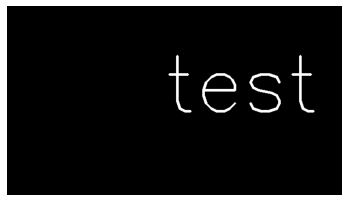

In [49]:
test = np.zeros_like(view_mask)
test = cv2.putText(test, 'test', (300,200), cv2.FONT_HERSHEY_SIMPLEX, 5, 255, 3)

plt.imshow(test, cmap='gray')
plt.axis('off')
plt.show()

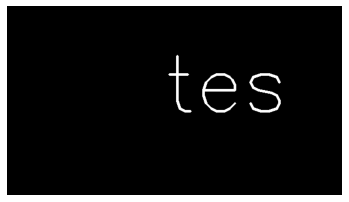

In [50]:
tt = test & view_mask

plt.imshow(tt, cmap='gray')
plt.axis('off')
plt.show()

In [64]:
a = np.array([np.nan,np.nan])
np.isnan(a).all()

True